## 1. Non-Central T Distribution

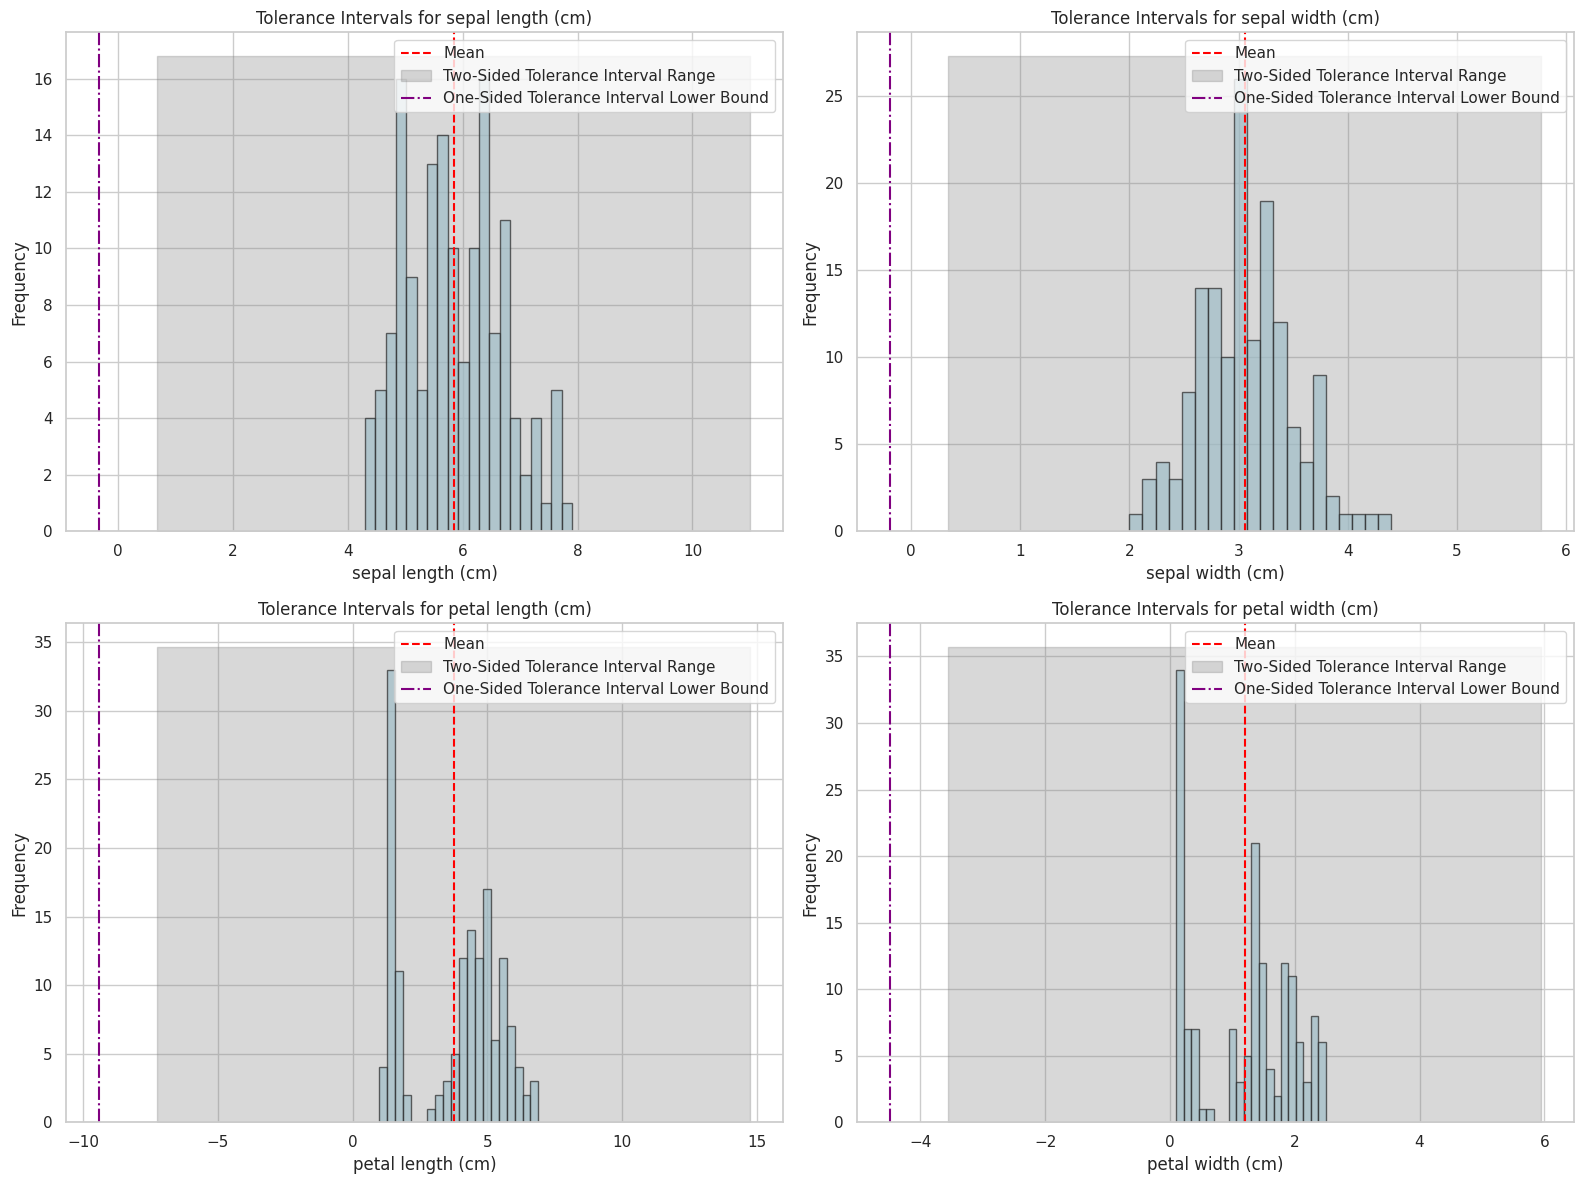

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t

# Iris 데이터셋 로드
from sklearn.datasets import load_iris
data = load_iris()
iris_df = pd.DataFrame(data.data, columns=data.feature_names)

# Tolerance interval 계산 함수
def two_sided_tolerance_interval(data, confidence_level, proportion_of_population):
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    
    alpha = 1 - confidence_level
    z = norm.ppf(1 - alpha / 2)
    k = np.sqrt((n - 1) * (1 + 1/n) * (1 + z**2 / (2 * (n - 1))) / (t.ppf(1 - alpha / 2, n - 1))**2)
    interval_radius = k * std
    
    return mean - interval_radius, mean + interval_radius

def one_sided_tolerance_interval(data, confidence_level):
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    
    alpha = 1 - confidence_level
    z = norm.ppf(1 - alpha)
    k = np.sqrt(n * (1 + z**2 / n) / (t.ppf(1 - alpha, n - 1))**2)
    interval_radius = k * std
    
    return mean - interval_radius

# 각 feature에 대해 tolerance interval 계산
confidence_level = 0.95
proportion_of_population = 0.90

intervals_two_sided = {}
intervals_one_sided = {}

for column in iris_df.columns:
    intervals_two_sided[column] = two_sided_tolerance_interval(iris_df[column], confidence_level, proportion_of_population)
    intervals_one_sided[column] = one_sided_tolerance_interval(iris_df[column], confidence_level)

# 그래프 설정
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, column in enumerate(iris_df.columns):
    data = iris_df[column]
    mean = np.mean(data)
    lower_two_sided, upper_two_sided = intervals_two_sided[column]
    lower_one_sided = intervals_one_sided[column]
    
    ax = axes[i]
    ax.hist(data, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
    ax.axvline(mean, color='red', linestyle='--', label='Mean')
    
    # Two-sided tolerance interval 범위 시각화
    ax.fill_betweenx([0, ax.get_ylim()[1]], lower_two_sided, upper_two_sided, color='gray', alpha=0.3, label='Two-Sided Tolerance Interval Range')

    # One-sided tolerance interval 범위 시각화
    ax.axvline(lower_one_sided, color='purple', linestyle='-.', label='One-Sided Tolerance Interval Lower Bound')
    
    ax.set_title(f'Tolerance Intervals for {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()


그러나, 실제 petal length는 0 이하가 될 수 없음. 즉, 이 경우에는 normality를 가정하기보다는 order statistics 를 이용하는 것이 바람직하다.

## Non-parametric : Order statistics

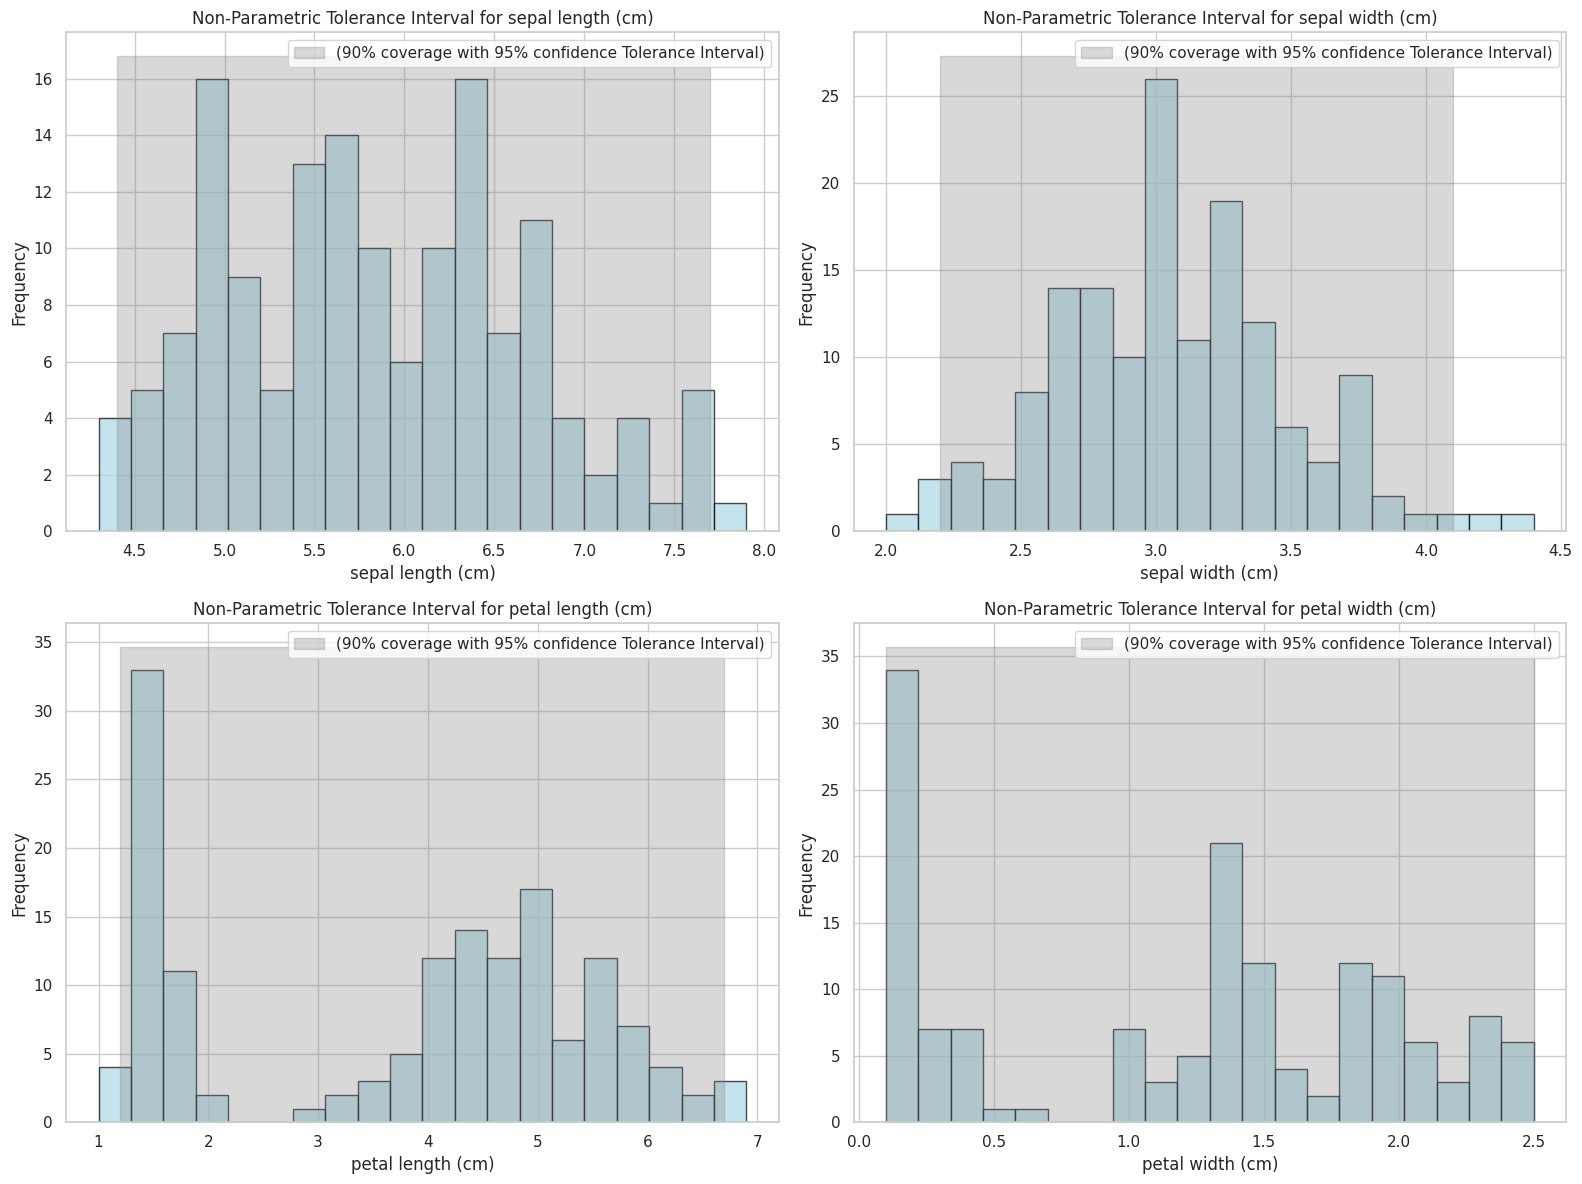

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Iris 데이터셋 로드
from sklearn.datasets import load_iris
data = load_iris()
iris_df = pd.DataFrame(data.data, columns=data.feature_names)

# 각 feature에 대해 tolerance interval 계산
intervals = {}
for column in iris_df.columns:
    data = iris_df[column]
    sorted_data = np.sort(data)
    
    # 6번째 값과 45번째 값을 허용 구간의 하한과 상한으로 설정
    lower_bound = sorted_data[2]  # 3번째 값 (0-based index: 2)
    upper_bound = sorted_data[147] # 148번째 값 (0-based index: 147)
    
    intervals[column] = [lower_bound, upper_bound]

# 그래프 설정
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, column in enumerate(iris_df.columns):
    data = iris_df[column]
    lower_bound, upper_bound = intervals[column]
    
    ax = axes[i]
    ax.hist(data, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
    
    
    # Tolerance Interval 범위 시각화
    ax.fill_betweenx([0, ax.get_ylim()[1]], lower_bound, upper_bound, color='gray', alpha=0.3, label='(90% coverage with 95% confidence Tolerance Interval)')
    
    ax.set_title(f'Non-Parametric Tolerance Interval for {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()



## 2. Linear Regression

### Two-sided

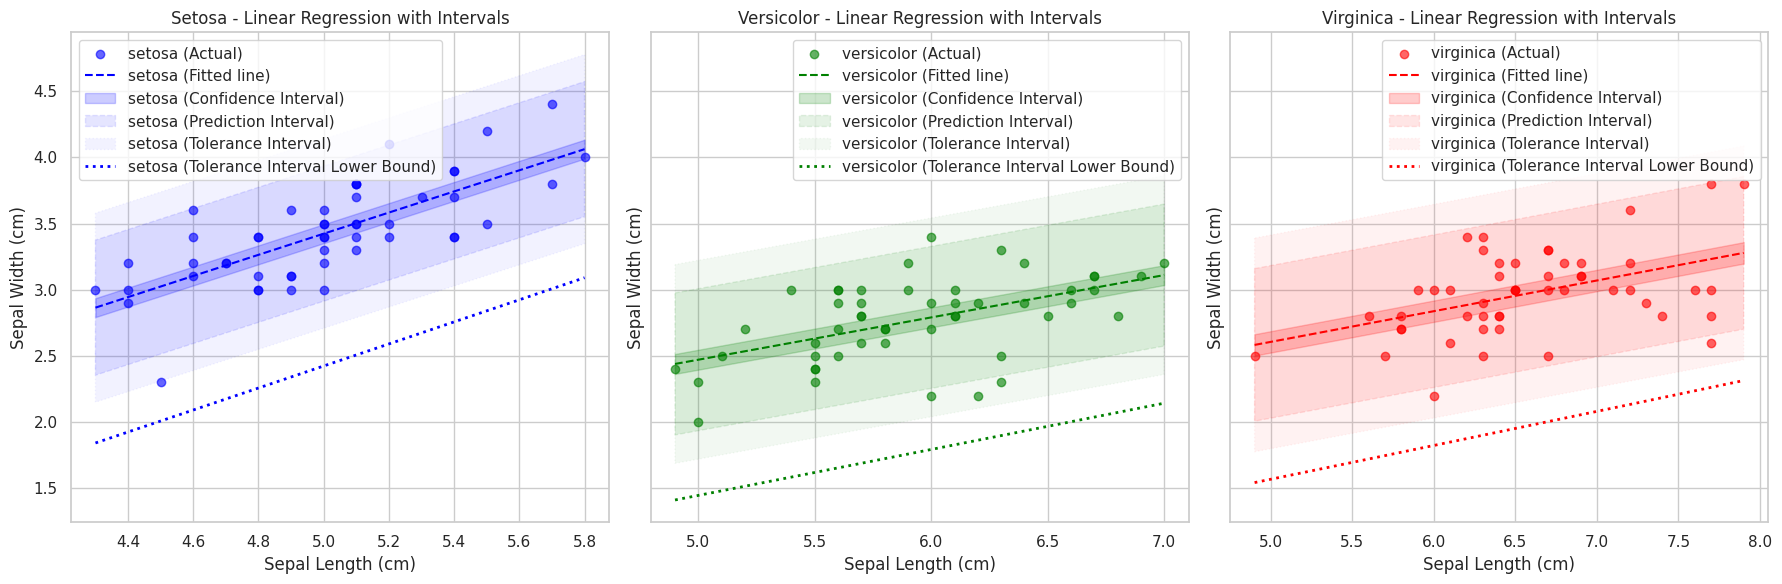

In [169]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_iris
from scipy import stats

# Iris 데이터셋 로드
data = load_iris()
iris_df = pd.DataFrame(data.data, columns=data.feature_names)
iris_df['species'] = data.target

# Species 이름 매핑
species_map = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
iris_df['species'] = iris_df['species'].map(species_map)

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# Plot 설정
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# 허용 구간의 신뢰 수준
confidence_level = 0.95
alpha = 1 - confidence_level

# 색상 설정
colors = {'setosa': 'blue', 'versicolor': 'green', 'virginica': 'red'}

for i, species in enumerate(colors.keys()):
    subset = iris_df[iris_df['species'] == species]
    X = subset[['sepal length (cm)']].values
    y = subset['sepal width (cm)'].values
    
    # 선형 회귀 모델 생성 및 훈련
    model = LinearRegression()
    model.fit(X, y)
    
    # 예측값 계산
    y_pred = model.predict(X)
    
    # 잔차 계산
    residuals = y - y_pred
    se = np.sqrt(np.mean(residuals**2))  # 표준 오차
    
    # t-분포의 분위수 값을 사용하여 신뢰 구간과 예측 구간의 오차 한계 계산
    n = len(X)
    df = n - 2  # 자유도 (데이터 포인트 수 - 추정된 파라미터 수)
    t_value = stats.t.ppf(1 - alpha / 2, df)
    
    # 신뢰 구간 (회귀선에 대한 신뢰 구간) 계산
    confidence_margin = t_value * se / np.sqrt(n)
    
    # 예측 구간 (새로운 데이터 포인트에 대한 예측 구간) 계산
    prediction_margin = t_value * se * np.sqrt(1 + 1/n)
    
    # 허용 구간 (전체 데이터 비율을 고려한 허용 구간) 계산
    tolerance_margin = t_value * se * np.sqrt(1 + 1/n + (1/n) * (n - 1))
    
    x_values = np.linspace(X.min(), X.max(), 100)
    y_fit = model.predict(x_values.reshape(-1, 1))
    conf_interval_lower = y_fit - confidence_margin
    conf_interval_upper = y_fit + confidence_margin
    pred_interval_lower = y_fit - prediction_margin
    pred_interval_upper = y_fit + prediction_margin
    tol_interval_lower = y_fit - tolerance_margin
    tol_interval_upper = y_fit + tolerance_margin

    # 원-사이드 허용 구간 (하한만) 계산
    tol_interval_lower_only = np.zeros_like(x_values)
    for j, x_val in enumerate(x_values):
        x_val = np.array([[x_val]])
        y_fit_at_x = model.predict(x_val)
        
        # H 계산
        H = x_val.dot(np.linalg.inv(X.T.dot(X))).dot(x_val.T)

        # Noncentrality 계산
        nc = -1*stats.norm.ppf(0.90)/np.sqrt(H) #P = 0.90(모집단의 90%를 포함하는 신뢰도 95%의 tolerance interval을 계산하고자 함)
        
        # t-분포의 분위수 값을 사용하여 허용 구간의 마진 계산
        t_value_one_sided = stats.nct.ppf(1 - alpha, df, nc)
        tolerance_margin_at_x = t_value_one_sided * -1 * np.sqrt(H)
        
        tol_interval_lower_only[j] = y_fit_at_x - tolerance_margin_at_x
        
    
    # 서브플롯 설정
    ax = axes[i]
    ax.scatter(X, y, color=colors[species], label=f'{species} (Actual)', alpha=0.6)
    ax.plot(x_values, y_fit, color=colors[species], linestyle='--', label=f'{species} (Fitted line)')
    
    # 신뢰 구간 시각화
    ax.fill_between(x_values, conf_interval_lower, conf_interval_upper, color=colors[species], alpha=0.2, label=f'{species} (Confidence Interval)')
    
    # 예측 구간 시각화
    ax.fill_between(x_values, pred_interval_lower, pred_interval_upper, color=colors[species], alpha=0.1, linestyle='--', label=f'{species} (Prediction Interval)')
    
    # 허용 구간 시각화
    ax.fill_between(x_values, tol_interval_lower, tol_interval_upper, color=colors[species], alpha=0.05, linestyle=':', label=f'{species} (Tolerance Interval)')

    # 원-사이드 허용 구간 시각화 (하한만)
    ax.plot(x_values, tol_interval_lower_only, color=colors[species], linestyle=':', linewidth=2, label=f'{species} (Tolerance Interval Lower Bound)')
    
    # 각 서브플롯 꾸미기
    ax.set_xlabel('Sepal Length (cm)')
    ax.set_ylabel('Sepal Width (cm)')
    ax.set_title(f'{species.capitalize()} - Linear Regression with Intervals')
    ax.legend()

plt.tight_layout()
plt.show()
